# Homework 2: Programming

The following notebook contains skeleton-code for answering problems 2 and 3 of homework assignment 2. Please read through each cell carefully to understand what is expected to be implemented. For your final submission, please try to clean up any intermediate outputs used for debugging.

### Imports

You should be able to complete the entire assignment using only the following imports. Please consult the course staff if you are unsure about whether additional packages may be used.

In [16]:
## Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt

## Question 2


Below we provide an AutoGrad class named `Value`. The basic idea is to store the existing computational map during the creation of each `Value`, and calculate the gradient using backpropagation when one of the `Value` calls `backward()` method.

The `backward()` function will arange the computational graph and backpropagate the gradients. All you need to do is to implement all the operations with its corresponding `_backward` function. We have provided the `__add__` function (sum of two nodes) as an example to help get you started.

This notebook is designed in a Object Oriented way, if you are not farmiliar with the Object Oriented Programming in Python, you can refer to:

(1) https://realpython.com/python3-object-oriented-programming/

(2) https://docs.python.org/3/tutorial/classes.html


In [17]:
from numpy import e


class Value:

    """
    Basic unit of storing a single scalar value and its gradient
    """

    def __init__(self, data, _children=()):
        """

        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda: None

    def __ge__(self, other):
        """computing greater than or equal to"""

        if isinstance(other, Value):
            return self.data >= other.data

    def __add__(self, other):
        """
        Example implementation of a single class operation (addition)

        Args:
            other (Any): Node to add with the class

        Returns:
            out (callable): Function to referesh the gradient
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data + other.data, (self, other))

        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation (e.g. Value(3) * Value(2) = Value(6))
        """
        
        other = other if isinstance(other, Value) else Value(other)

        out = Value(other.data * self.data, (self, other))

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        """
        Power operation (e.g Value(3) ** 2 = Value(9))
        """
        assert isinstance(other, (int, float))

        out = Value(self.data ** other, (self,))

        def _backward():
            self.grad += out.grad * (other * (self ** (other -1)))
        out._backward = _backward
        return out
    

    def relu(self):
        """
        ReLU activation function applied to the current Value
        """
        out = Value(max(0, self.data), (self,))

        def _backward():
            if self.data > 0:
                self.grad += out.grad * 1.0
            else:
                self.grad += out.grad * 0.0
        out._backward = _backward
        return out


    def exp(self):
        """
        Exponentiate the current Value (e.g. e ^ Value(0) = Value(1))
        """
        out = Value(np.exp(self.data), (self,))

        def _backward():
            self.grad += out.grad * (np.exp(self.data))
        out._backward = _backward
        return out 

    def log(self):
        """
        Take the natural logarithm (base e) of the current Value
        """

        out = Value(np.log(self.data), (self,))

        def _backward():
            self.grad += out.grad * (1.0 / self.data)
        out._backward = _backward

        return out

    def backward(self):
        """
        Run backpropagation from the current Value
        """
        #This function is called when you start backpropagation from this Value

        #The gradient of this value is initialized to 1 for you.
        self.grad = 1

        #You need to find a right topological order all of the children in the graph.
        #As for topology sort, you can refer to http://www.cs.cornell.edu/courses/cs312/2004fa/lectures/lecture15.htm

        topo = []
        visited = set()  # a set containing all nodes waiting to be visited


        def visit(node):
            if node not in visited:
                visited.add(node)

                for child in node._prev:
                    visit(child)

                topo.insert(0, node) # adding current node to the head


        visit(self)

        topo = topo[::-1]

        for v in topo:
            v._backward()

    # We handled the negation and reverse operations for you
    def __neg__(self): # -self
        """
        Negate the current Value
        """
        return self * -1

    def __radd__(self, other): #other + self
        """
        Reverse addition operation (ordering matters in Python)
        """
        return self + other

    def __sub__(self, other): # self - other
        """
        Subtraction operation
        """
        return self + (-other)

    def __rsub__(self, other): # other - self
        """
        Reverse subtraction operation
        """
        return other + (-self)

    def __rmul__(self, other): # other * self
        """
        Reverse multiplication operation
        """
        return self * other

    def __truediv__(self, other): # self / other
        """
        Division operation
        """
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        """
        Reverse diction operation
        """
        return other * self**-1

    def __repr__(self):
        """
        Class representation (instead of unfriendly memory address)
        """
        return f"Value(data={self.data}, grad={self.grad})"

In [18]:
def sigmoid(x):
    """
    Sigmoid activation function.
    """
    return 1 / (1 + np.exp(-x))


Now, we are going to use the simple example in q1.b to get you familar with the usage of this class.

If your implementation is correct, you will get the same values and gradients as your hand-caculated ones.

Be careful! Even you get this test case right, it does not guarantee the correctness of your implementation.

In [19]:
## Initialize Example Values (From Written Assignment)
w1 = Value(0.3)
w2 = Value(-0.5)
x1 = Value(0.2)
x2 = Value(0.4)

#TODO
#Do calculation for the question 1.b, and call backward to start backpropagation.
#Then print out the gradient of w1 w2 x1 x2.

a = w1 * x1
print(f"a = w1 * x1 = {w1.data} * {x1.data} = {a.data:.4f}")

b = w2 * x2
print(f"b = w2 * x2 = {w2.data} * {x2.data} = {b.data:.4f}")
c = a + b
print(f"c = a + b = {a.data:.4f} + {b.data:.4f} = {c.data:.4f}")
d = sigmoid(c)
print(f"d = sigmoid(c) = sigmoid({c.data:.4f}) = {d.data:.4f}")
e = w1 ** 2
print(f"e = w1 ** 2 = {w1.data} ** 2 = {e.data:.4f}")
g = w2 ** 2
print(f"g = w2 ** 2 = {w2.data} ** 2 = {g.data:.4f}")
h = e + g
print(f"h = e + g = {e.data:.4f} + {g.data:.4f} = {h.data:.4f}")
i = Value(0.5) * h
print(f"i = 0.5 * h = 0.5 * {h.data:.4f} = {i.data:.4f}")
f = d + i
print(f"f = d + i = {d.data:.4f} + {i.data:.4f} = {f.data:.4f}")

f.backward()

print(f"w1.grad: {w1.grad}, w2.grad: {w2.grad}, x1.grad: {x1.grad}, x2.grad: {x2.grad}")




a = w1 * x1 = 0.3 * 0.2 = 0.0600
b = w2 * x2 = -0.5 * 0.4 = -0.2000
c = a + b = 0.0600 + -0.2000 = -0.1400
d = sigmoid(c) = sigmoid(-0.1400) = 0.4651
e = w1 ** 2 = 0.3 ** 2 = 0.0900
g = w2 ** 2 = -0.5 ** 2 = 0.2500
h = e + g = 0.0900 + 0.2500 = 0.3400
i = 0.5 * h = 0.5 * 0.3400 = 0.1700
f = d + i = 0.4651 + 0.1700 = 0.6351
w1.grad: Value(data=0.0, grad=0), w2.grad: Value(data=0.0, grad=0), x1.grad: 0.0, x2.grad: 0.0


## Question 3

### Implementation of the linear layer
You will implement a `LinearLayer` module here.

We provide the initialization of the class `LinearLayer`. You need to implement the forward function -- Return the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.


In [20]:
class Module:

    """
    Base Model Module
    """

    def parameters(self):
        """

        """
        return []

    def zero_grad(self):
        """

        """
        for p in self.parameters():
            p.grad = 0

class LinearLayer(Module):

    """
    Linear Layer
    """

    def __init__(self, nin, nout):
        """
        Here we randomly initilize the weights w as 2-dimensional list of Values
        And b as 1-dimensional list of Values with value 0

        You may use this stucture to implement the __call__ function
        """
        self.w = []
        for i in range(nin):
            w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
            self.w.append(w_tmp)
        self.b = [Value(0) for i in range(nout)]
        self.nin = nin
        self.nout = nout

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """

        batch_size = len(x)
        xout = [[Value(0) for j in range(self.nout)] for i in range(batch_size)]

        # matrix multiplication
        for i in range(batch_size):
            for j in range(self.nout):
                w_sum = Value(0.0)

                for k in range(self.nin):
                    w_sum += self.w[k][j] * x[i][k]

                xout[i][j] = w_sum + self.b[j]
        return xout

    def parameters(self):
        """
        Get the list of parameters in the Linear Layer

        Args:
            None

        Returns:
            params (list): List of parameters in the layer
        """
        return [p for row in self.w for p in row] + [p for p in self.b]

Test your implementation of linear layer, the error should be nearly 0.

In [21]:
## Initialization of Layer with Weights
linear_model_test = LinearLayer(4, 4)
linear_model_test.w = [[Value(data=0.7433570245252463), Value(data=-0.9662164096144394), Value(data=-0.17087204941322653), Value(data=-0.5186656374983067)],
                       [Value(data=-0.1414882837892344), Value(data=-0.5898971049017006), Value(data=-0.3448340220492381), Value(data=0.5278833226346107)],
                       [Value(data=0.3990701306597799), Value(data=-0.3319058654296163), Value(data=-0.784797384411202), Value(data=0.7603317495966846)],
                       [Value(data=-0.5711035064293541), Value(data=-0.0001937643033362857), Value(data=0.12693226232877053), Value(data=-0.36044237239197097)]]
linear_model_test.b = [Value(data=0), Value(data=0), Value(data=0), Value(data=0)]

## Forward Pass
x_test = [[-0.17120438454836173, -0.3736077734087335, -0.48495413054653214, 0.8269206715993096]]
y_hat_test = linear_model_test(x_test)
y_ref = [[Value(data=-0.7401928625441141), Value(data=0.5466095223360173), Value(data=0.6436403600545564), Value(data=-0.7752067527386406)]]

## Error Calculation
predict_error = 0
for i in range(4):
    predict_error += (y_hat_test[0][i] - y_ref[0][i])**2
print(predict_error.data)

0.0


### Implementation of Loss functions

You will implement softmax, cross entropy loss, and accuracy here for further use

In [22]:
def softmax(y_hat):
    """
    Softmax computation

    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]

    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat
    """

    y_hat_exp = [[element.exp() for element in row] for row in y_hat]  # e^s_ij

    sum_exp = [sum(row) for row in y_hat_exp] #summation ove each row

    s = [[y_hat_exp[i][j] / sum_exp[i] for j in range(len(y_hat[0]))] for i in range(len(y_hat))] # s_ij = e^s_ij / sum(e^s_ik)

    return s

In [23]:
def cross_entropy_loss(y_hat, y):
    """
    Cross-entropy Loss computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]

    Returns:
        loss (Value): Loss value of type Value
    """

    s = softmax(y_hat)  # softmax output

    batch_size = len(y)
    class_size = len(y_hat[0])

    loss = Value(0.0)

    for i in range(batch_size):
        for j in range(class_size): 
            if j == y[i]:
                loss = loss + -(s[i][j].log())  # cross-entropy loss

    return loss / batch_size

In [24]:
def accuracy(y_hat, y):
    """
    Accuracy computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]

    Returns:
        acc (float): Accuracy score
    """
    batch_size = len(y)
    class_size = len(y_hat[0])

    correct = 0

    for i in range(batch_size):
        predicted_class = 0
        max_prob = y_hat[i][0].data
        

        for j in range(class_size):
            temp = y_hat[i][j].data
            max_btwn = np.maximum(max_prob, y_hat[i][j].data)
            if max_btwn == y_hat[i][j].data:
                max_prob = y_hat[i][j].data
                predicted_class = j
        
        true_class = y[i]
        
        if predicted_class == true_class:
            correct += 1

    acc = correct / batch_size

    return acc

Test the implementation of `softmax()` and `cross_entropy_loss()` as well as the gradient calculation of `Value` class. The errors should be nearly 0.

In [25]:
## Ground Truth + Forward Pass
y_gt = [1]
y_hat_test = linear_model_test(x_test)

## Softmax Calculation
prob_test = softmax(y_hat_test)
prob_ref = [[0.10441739448437284, 0.37811510516540814, 0.4166428991676558, 0.10082460118256342]]
softmax_error = 0
for i in range(4):
    softmax_error += (prob_ref[0][i] - prob_test[0][i])**2
print(softmax_error.data)

## Cross Entropy Loss Calculation
loss_test = cross_entropy_loss(y_hat_test, y_gt)
loss_ref = Value(data=0.9725566186970217)
print((loss_test - loss_ref).data)

## Update Gradient Based on Loss
linear_model_test.zero_grad()
loss_test.backward()
w_gradient_ref = [[-0.017876715758840547, 0.10646942068007896, -0.07133109112844363, -0.01726161379279479],
                  [-0.0390111502584479, 0.23234103087567629, -0.1556610258645873, -0.03766885475264107],
                  [-0.05063764675610328, 0.30158564847453107, -0.2020526949142369, -0.04889530680419089],
                  [0.08634490197366762, -0.5142494748940867, 0.3445306259968013, 0.08337394692361787]]
b_gradient_ref = [0.10441739448437282, -0.6218848948345919, 0.4166428991676557, 0.1008246011825634]

## Compute Error
w_gradient_error = 0
b_gradient_error = 0
for i in range(4):
    b_gradient_error += (linear_model_test.b[i].grad - b_gradient_ref[i]) ** 2
    for j in range(4):
        w_gradient_error += (linear_model_test.w[i][j].grad - w_gradient_ref[i][j]) ** 2
print(w_gradient_error)
print(b_gradient_error)

0.0
0.0
0.6324895734284675
0.5814007203247888


Implement the following functions to visualize the ground truth and the decision boundary in the same figure.

In [26]:
def plot_points(X, Y, scale, n, data):
    """
    Plot points in the visualization image
    """
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]

    for i in range(X.shape[0]):
        x1 = X[i,0]
        x2 = X[i,1]
        label = Y[i]
        x_pixel = int((x1 + scale) / (2 * scale) * n)
        y_pixel = int((x2 + scale) / (2 * scale) * n)



        if 0 <= x_pixel < n and 0 <= y_pixel < n: # if value pixel     
            data[y_pixel, x_pixel] = points_color[label]

    return data


def plot_background(scale, n, model):
    """
    Color the background in the visualization image
    """

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]

    data = np.zeros((n,n,3), dtype='uint8')

    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]

            prediction = model(input)  # model prediction
            label = np.argmax([prediction[0][k].data for k in range(len(prediction[0]))])
            data[i, j] = background_color[label]
    return data


def visualization(X, Y, model):
    """
    Decision boundary visualization
    """
    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels

    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)

    plt.imshow(data)
    plt.axis('off')
    plt.show()

if you implement the plot function correctly, you will get some image like:

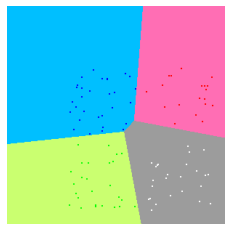


### Implementation of training procedure

With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs training iterations

In [ ]:
def train(x,
          y,
          model,
          loss_function=cross_entropy_loss,
          accuracy_function=accuracy,
          max_iteration=500,
          learning_rate=1):
    """
    Args:
       x (2-d list): List of Values with shape: [n_samples, n_channels]
       y (1-d list): List of integers with shape: [n_samples]
       model (Module): Linear model
       loss_function (callable): Loss function to use during training
       accuracy_function (callable): Function used for calculating training accuracy
       max_iteration (int): Number of epochs to train model for
       learning_rate (numeric): Step size of the gradient update
    """


    for i in range(max_iteration):
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        acc = accuracy_function(y_hat, y)

        

        model.zero_grad()
        loss.backward()

        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
            parameter.grad = 0.0        


        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        
        ## record loss
        if i == 0 :
        # initialize L
            L = loss.data
            A = acc
        else:
            L = np.append(L,loss.data)
            A = np.append(A,acc)

    ## Plot Loss and Accuracy
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()


### Train the model

Load the data, format it, instantiate your model and start training!

(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 1.6155299797811677 accuracy: 0.27
iteration 39 loss: 1.6155299797811677 accuracy: 0.27
iteration 59 loss: 1.6155299797811677 accuracy: 0.27
iteration 79 loss: 1.6155299797811677 accuracy: 0.27
iteration 99 loss: 1.6155299797811677 accuracy: 0.27
iteration 119 loss: 1.6155299797811677 accuracy: 0.27
iteration 139 loss: 1.6155299797811677 accuracy: 0.27
iteration 159 loss: 1.6155299797811677 accuracy: 0.27
iteration 179 loss: 1.6155299797811677 accuracy: 0.27
iteration 199 loss: 1.6155299797811677 accuracy: 0.27
iteration 219 loss: 1.6155299797811677 accuracy: 0.27
iteration 239 loss: 1.6155299797811677 accuracy: 0.27
iteration 259 loss: 1.6155299797811677 accuracy: 0.27
iteration 279 loss: 1.6155299797811677 accuracy: 0.27
iteration 299 loss: 1.6155299797811677 accuracy: 0.27
iteration 319 loss: 1.6155299797811677 accuracy: 0.27
iteration 339 loss: 1.6155299797811677 accuracy: 0.27
iteration 359 loss: 1.6155299797811677 accuracy: 0.27
iterati

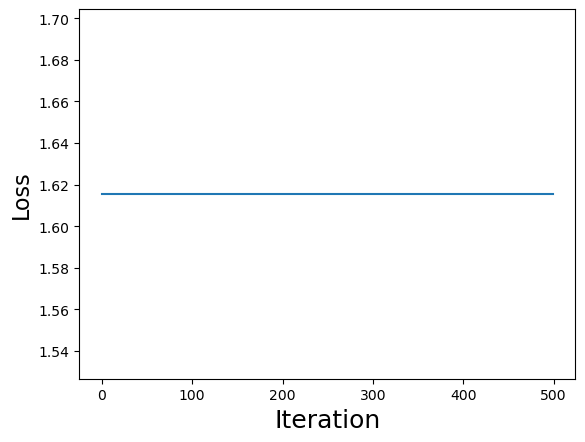

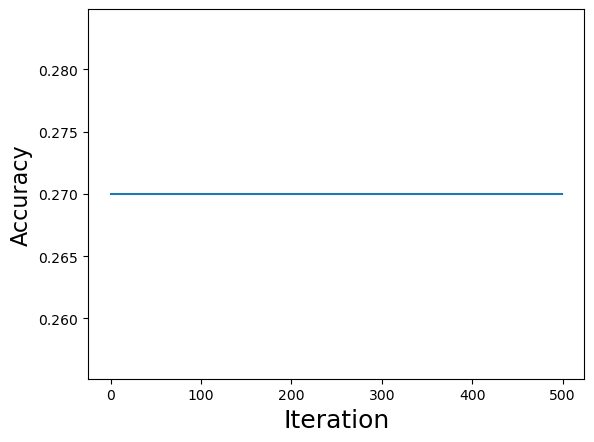

In [28]:
## Load Q3 Dataset
import numpy as np

svpath = 'HW2_Q3_dataset/Q3_data.npz'
data = np.load(svpath)

# X, array of shape [n_samples, n_features]
# Y, array of shape [n_samples]
X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

## Initialize data using your Value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

## Initialize a Linear Model
linear_model = LinearLayer(nin, nout)

## Train the Model using Your Data
train(x, y, linear_model)

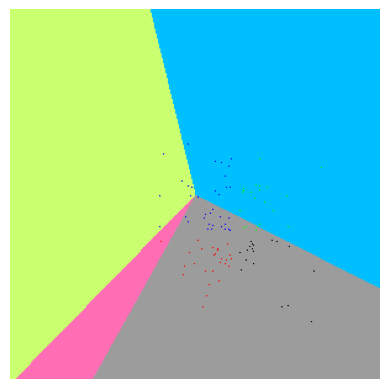

In [29]:
## Visualize learned decision boundaries
visualization(X, Y, linear_model)

## Question 4

### a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [30]:
## Load Q4 Dataset
datapath = 'HW2_Q3_dataset/Q4_data.npz'
data = np.load(datapath)

## Parse Data and Identify Dimensions
X = data['X']
Y = data['Y']
nin = X.shape[1]
nout = int(np.max(Y)) + 1

## Initialize data using your value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

FileNotFoundError: [Errno 2] No such file or directory: 'HW2_Q3_dataset/Q4_data.npz'

In [ ]:
## Initialize Linear Model
linear_model = LinearLayer(nin, nout)

## Train Model
train(x, y, linear_model)

In [ ]:
## Visualize Learned Decision Boundary
visualization(X, Y, linear_model)

### b) Implementation of Multi Layer Perceptron (MLP)

Implement a class `MLP` to add arbitrary layers. You will need to implement the forward function to return results `out` with `x` fed into the model.

In [ ]:
class MLP(Module):

    """
    Multi Layer Perceptron
    """
    def __init__(self, dimensions):
        """
        Initialize multiple layers here in the list named self.linear_layers
        """
        assert isinstance(dimensions, list)
        assert len(dimensions) > 2
        self.linear_layers = []
        for i in range(len(dimensions) - 1):
            self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO Implement this function and return the output of a MLP
        return NotImplementedError

    def parameters(self):
        """
        Get the parameters of each layer

        Args:
            None

        Returns:
            params (list of Values): Parameters of the MLP
        """
        return [p for layer in self.linear_layers for p in layer.parameters()]

    def zero_grad(self):
        """
        Zero out the gradient of each parameter
        """
        for p in self.parameters():
            p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

In [ ]:
## Initialize MLP with Given Parameters
mlp_model = MLP([nin, 40, nout])

## Train the MLP
train(x, y, mlp_model)

In [ ]:
## Visualize Decision Boundaries
visualization(X, Y, mlp_model)

## Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd